# InSituPy Demonstration - Build an InSituData Object from Scratch

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import geopandas as gpd
import dask.array as da
from shapely.geometry import Polygon
from insitupy import InSituData
from insitupy._core.dataclasses import CellData, BoundariesData, ImageData, AnnotationsData, RegionsData
from pathlib import Path

### Let's start by generating main modalities and adding them into InSituData

#### First, let's generate an H&E-like random numpy image

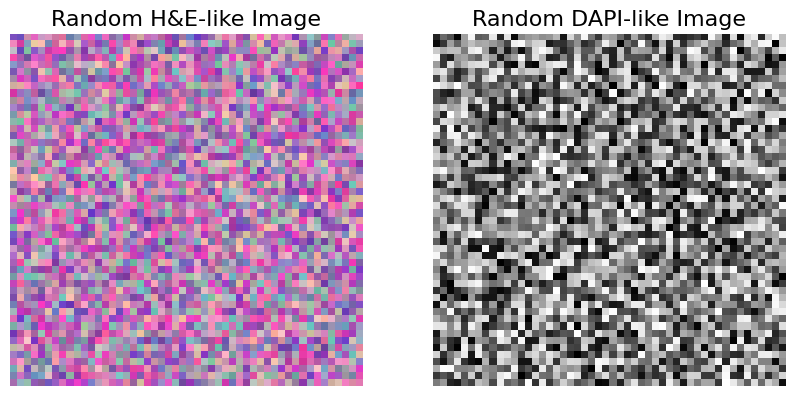

In [3]:
x_size = 50
y_size = 50
n_cells = 50
pixel_size = 0.2125

# Function to generate a random H&E-like image
def generate_random_he_image(height, width):
    # Hematoxylin (blue-purple) and Eosin (pink) color ranges
    hematoxylin_color = np.array([0.4, 0.2, 0.6])
    eosin_color = np.array([1.0, 0.8, 0.8])
    
    random_image = np.random.rand(height, width, 3)
    he_image = random_image * hematoxylin_color + (1 - random_image) * eosin_color
    
    return he_image

# Function to generate a random grayscale DAPI-like image
def generate_random_dapi_image(height, width):
    # DAPI (blue) color range in grayscale
    dapi_color = np.array([0.1, 0.1, 0.8])
    
    random_image = np.random.rand(height, width)
    dapi_image = random_image * dapi_color[2]  # Use the blue channel for grayscale
    
    return dapi_image

# Generate H&E-like image
he_image = generate_random_he_image(x_size, y_size)

# Generate DAPI-like image
dapi_image = generate_random_dapi_image(x_size, y_size)

# Display the generated images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(he_image)
plt.title("Random H&E-like Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dapi_image, cmap='gray')
plt.title("Random DAPI-like Image")
plt.axis('off')

plt.show()

#### In the next step we generate AnnData object with respective spatial coordinates and a Dask Array with cell boundaries for the cells in the AnnData object

In [5]:
pixel_coordinates = np.random.rand(n_cells, 2) * [50, 50]

# Convert pixel coordinates to micrometers (1 pixel = 0.2125 micrometers)
micrometer_coordinates = pixel_coordinates * pixel_size

# Generate random gene expression counts matrix (n_cells x num_genes)
num_genes = 10
gene_counts = np.random.poisson(lam=5, size=(n_cells, num_genes))

# Create an AnnData object with gene expression counts and spatial coordinates
adata = ad.AnnData(X=gene_counts)
adata.obsm['spatial'] = micrometer_coordinates
# Example observations (metadata)
obs_data = {
    'cell_type': ['type1', 'type2'] * (n_cells // 2),  # Example cell types
    'batch': ['batch1'] * (n_cells // 2) + ['batch2'] * (n_cells // 2)  # Example batch information
}

# Add observations to the obs attribute
adata.obs = adata.obs.assign(**obs_data)
adata

AnnData object with n_obs × n_vars = 50 × 10
    obs: 'cell_type', 'batch'
    obsm: 'spatial'

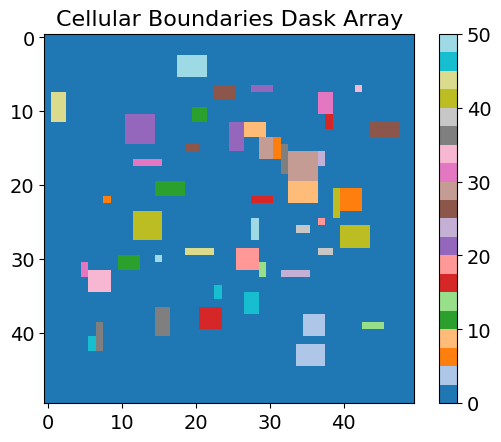

In [10]:
# Function to generate a cellular boundaries Dask array
def generate_cellular_boundaries_array(height, width, num_cells):
    # Initialize an empty array with zeros
    array = np.zeros((height, width), dtype=int)
    
    # Randomly generate cell boundaries and assign cell IDs
    for cell_id in range(1, num_cells + 1):
        while True:
            # Randomly choose the top-left corner of the cell
            top_left_x = np.random.randint(0, height - 5)
            top_left_y = np.random.randint(0, width - 5)
            
            # Randomly choose the size of the cell
            cell_height = np.random.randint(1, 5)
            cell_width = np.random.randint(1, 5)
            
            # Check if the chosen region is empty (no intersection with other cells)
            if np.all(array[top_left_x:top_left_x + cell_height, top_left_y:top_left_y + cell_width] == 0):
                # Assign the cell ID to the chosen region
                array[top_left_x:top_left_x + cell_height, top_left_y:top_left_y + cell_width] = cell_id
                break
    
    # Convert the NumPy array to a Dask array with chunks
    dask_array = da.from_array(array, chunks=(50, 50))
    
    return dask_array

# Generate a cellular boundaries Dask array
cellular_boundaries_array = generate_cellular_boundaries_array(y_size, x_size, n_cells)

# Compute the Dask array to get a NumPy array
numpy_array = cellular_boundaries_array.compute()

# Plot the NumPy array
plt.imshow(numpy_array, cmap='tab20')
plt.title("Cellular Boundaries Dask Array")
plt.colorbar()
plt.show()

#### Let's also generate example annotations and regions

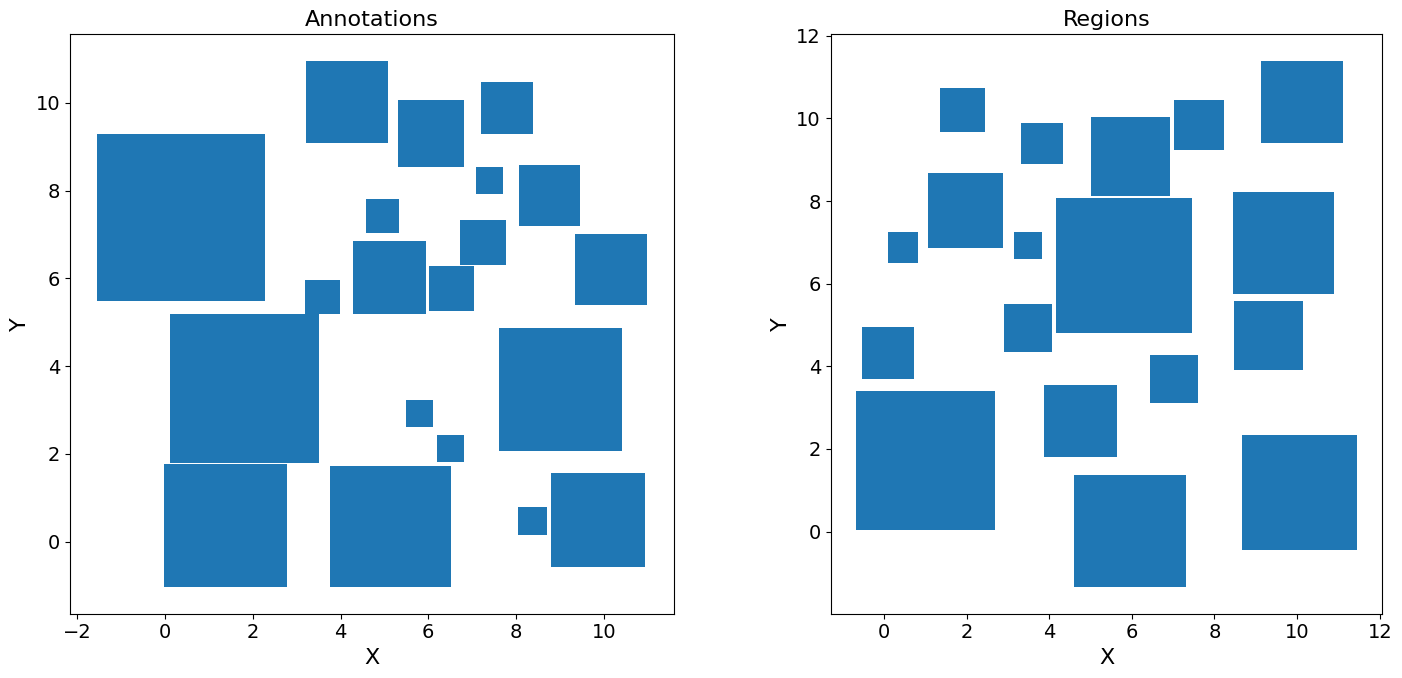

                                            geometry  id         name
0  POLYGON ((0.11922 1.79986, 3.49812 1.79986, 3....   0  annotation1
1  POLYGON ((-0.02818 -1.04441, 2.78619 -1.04441,...   1  annotation1
2  POLYGON ((8.79338 -0.58240, 10.93882 -0.58240,...   2  annotation1
3  POLYGON ((3.75553 -1.04162, 6.51207 -1.04162, ...   3  annotation1
4  POLYGON ((5.29976 8.54440, 6.82557 8.54440, 6....   4  annotation1
                                            geometry  id  name
0  POLYGON ((1.06433 6.86290, 2.87437 6.86290, 2....   0     0
1  POLYGON ((8.65774 -0.45205, 11.45771 -0.45205,...   1     1
2  POLYGON ((3.86830 1.79431, 5.63105 1.79431, 5....   2     2
3  POLYGON ((4.17719 4.81184, 7.45028 4.81184, 7....   3     3
4  POLYGON ((8.47310 3.90485, 10.14118 3.90485, 1...   4     4


In [ ]:
# Function to generate random polygons
def generate_random_polygons(num_polygons, x_size, y_size):
    polygons = []
    attempts = 0
    max_attempts = num_polygons * 10  # Limit the number of attempts to avoid infinite loop
    
    while len(polygons) < num_polygons and attempts < max_attempts:
        # Generate random center point
        center_x = np.random.uniform(0, x_size)
        center_y = np.random.uniform(0, y_size)
        
        # Generate random size for the polygon
        size = np.random.uniform(0.3, 2)
        
        # Create a square polygon around the center point
        polygon = Polygon([
            (center_x - size, center_y - size),
            (center_x + size, center_y - size),
            (center_x + size, center_y + size),
            (center_x - size, center_y + size)
        ])
        
        # Check if the new polygon intersects with any existing polygons
        if not any(polygon.intersects(existing_polygon) for existing_polygon in polygons):
            polygons.append(polygon)
        
        attempts += 1
    
    return polygons
# Generate random polygons
num_polygons = 20
random_polygons = generate_random_polygons(num_polygons, x_size*pixel_size, y_size*pixel_size)
# Create GeoDataFrame with random polygons
gdf_annotations = gpd.GeoDataFrame(geometry=random_polygons)
gdf_annotations["id"] = gdf_annotations.index
gdf_annotations["name"] = ['annotation1'] * (num_polygons // 2) + ['annotation2'] * (num_polygons // 2)


random_polygons = generate_random_polygons(num_polygons, x_size*pixel_size, y_size*pixel_size)
# Create GeoDataFrame with random polygons
gdf_regions = gpd.GeoDataFrame(geometry=random_polygons)
gdf_regions["id"] = gdf_regions.index
gdf_regions["name"] = gdf_regions.index

# Plot the two GeoDataFrames in one row
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

gdf_annotations.plot(ax=axes[0])
axes[0].set_title("Annotations")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")

gdf_regions.plot(ax=axes[1])
axes[1].set_title("Regions")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")

plt.tight_layout()
plt.show()


# Print the GeoDataFrame with random polygons
print(gdf_annotations.head())
print(gdf_regions.head())

## Let's create an InSituData object with all the modalities we have generated before

In [79]:
xd = InSituData(path=Path("dummy_path"), metadata={"metadata_file": Path("./")}, slide_id="slide", sample_id="sample_1", from_insitudata=False)

In [80]:
xd

InSituData
Method:		unknown
Slide ID:	slide
Sample ID:	sample_1
Path:		dummy_path
Metadata file:	.

In [87]:
bd = BoundariesData(cell_ids=None, seg_mask_value=None)
bd.add_boundaries(data={"cellular": cellular_boundaries_array}, pixel_size=pixel_size)

cd = CellData(matrix=adata, boundaries=bd)
setattr(xd, "cells", cd)

setattr(xd, "images", ImageData())
xd.images.add_image(image=he_image, name="H&E", axes="xyc", pixel_size=pixel_size, ome_meta={'PhysicalSizeX': pixel_size})
xd.images.add_image(image=dapi_image, name="nuclei", axes="xyc", pixel_size=pixel_size, ome_meta={'PhysicalSizeX': pixel_size})

setattr(xd, "annotations", AnnotationsData())
xd.annotations.add_data(gdf_annotations, key="example_annotation", scale_factor=1/pixel_size)
setattr(xd, "regions", RegionsData())
xd.regions.add_data(gdf_regions, key="example_regions", scale_factor=1/pixel_size)

In [88]:
xd

InSituData
Method:		unknown
Slide ID:	slide
Sample ID:	sample_1
Path:		dummy_path
Metadata file:	.
    ➤ images
       H&E:	(50, 50, 3)
       nuclei:	(50, 50)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 50 × 10
           obs: 'cell_type', 'batch'
           obsm: 'spatial'
       boundaries
           BoundariesData object with 1 entry:
               cellular
    ➤ annotations
       example_annotation:	20 annotations, 2 classes ('annotation1','annotation2') 
    ➤ regions
       example_regions:	18 regions, 18 classes 

In [92]:
xd.show()

C:\Users\Anna\InSituPy\insitupy\images\utils.py:203: UserWarning: Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.
  warnings.warn("Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.")


[dask.array<array, shape=(50, 50, 3), dtype=float64, chunksize=(50, 50, 3), chunktype=numpy.ndarray>, dask.array<astype, shape=(25, 25, 3), dtype=uint16, chunksize=(25, 25, 3), chunktype=numpy.ndarray>, dask.array<getitem, shape=(13, 13, 3), dtype=uint16, chunksize=(13, 13, 3), chunktype=numpy.ndarray>, dask.array<getitem, shape=(7, 7, 3), dtype=uint16, chunksize=(7, 7, 3), chunktype=numpy.ndarray>, dask.array<getitem, shape=(4, 4, 3), dtype=uint16, chunksize=(4, 4, 3), chunktype=numpy.ndarray>, dask.array<getitem, shape=(2, 2, 3), dtype=uint16, chunksize=(2, 2, 3), chunktype=numpy.ndarray>, dask.array<getitem, shape=(1, 1, 3), dtype=uint16, chunksize=(1, 1, 3), chunktype=numpy.ndarray>]


C:\Users\Anna\InSituPy\insitupy\images\utils.py:203: UserWarning: Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.
  warnings.warn("Image does not have dtype 'uint8' or 'uint16'. Is converted to 'uint16'.")


[dask.array<array, shape=(50, 50), dtype=float64, chunksize=(50, 50), chunktype=numpy.ndarray>, dask.array<astype, shape=(25, 25), dtype=uint16, chunksize=(25, 25), chunktype=numpy.ndarray>, dask.array<getitem, shape=(13, 13), dtype=uint16, chunksize=(13, 13), chunktype=numpy.ndarray>, dask.array<getitem, shape=(7, 7), dtype=uint16, chunksize=(7, 7), chunktype=numpy.ndarray>, dask.array<getitem, shape=(4, 4), dtype=uint16, chunksize=(4, 4), chunktype=numpy.ndarray>, dask.array<getitem, shape=(2, 2), dtype=uint16, chunksize=(2, 2), chunktype=numpy.ndarray>, dask.array<getitem, shape=(1, 1), dtype=uint16, chunksize=(1, 1), chunktype=numpy.ndarray>]
